<a href="https://colab.research.google.com/github/andreadosi1986/PrismaSVDUNet/blob/master/ProgettoCariocaDlRun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.6 MB/s 


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 26 08:13:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import tifffile as tiff
import tensorflow as tf
import keras
import pickle

In [ ]:
### IMPORT TRAINING TEST SET AND CORRISPONDING LABELLING ####

In [ ]:
X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train4classesNoNoise.npy')

In [ ]:
X_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_test4classesNoNoise.npy')
y_train_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_cat4classesNoNoise.npy')
y_test_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test_cat4classesNoNoise.npy')

In [ ]:
y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train4classesNoNoise.npy')
y_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test4classesNoNoise.npy')

In [ ]:
print(X_train.shape, X_test.shape, y_train_cat.shape, y_test_cat.shape)

(2673, 128, 128, 1) (669, 128, 128, 1) (2673, 128, 128, 4) (669, 128, 128, 4)


In [ ]:
#class_weight_array = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/class_weight.npy')

In [ ]:
#print(class_weight_array)

In [ ]:
#classes = np.array([0,1,2,3,4,5])

In [ ]:
#class_weight = {0:class_weight_array[0], 1:class_weight_array[1], 2:class_weight_array[2], 3:class_weight_array[3], 4:class_weight_array[4], 5:class_weight_array[5]}

In [ ]:
#from tensorflow.python.keras.engine.training_utils_v1 import standardize_weights
#standardize_weights(classes, class_weight=class_weight)

In [ ]:
import segmentation_models as sm
#class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
#dice_loss = sm.losses.DiceLoss(class_weights=class_weight_array) 
focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
#jaccard_loss = sm.losses.bce_jaccard_loss(class_weights=class_weight_array)

In [ ]:
################################################################ U-NET BUILD ###########################################

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes=4

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
#model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
#model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
#model.summary()

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss= focal_loss, metrics = ['accuracy'])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 128, 128, 16  160         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_99 (Dropout)           (None, 128, 128, 16  0           ['conv2d_209[0][0]']             
                                )                                                          

In [ ]:
import time
start = time.time()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=300, 
                    validation_data=(X_test, y_test_cat), 
                    #sample_weight=class_weight_array,
                    shuffle=False)

print("Total model fit time: ", time.time() - start, "seconds")

Epoch 1/300
168/168 [==============================] - 10s 47ms/step - loss: 0.0175 - accuracy: 0.7777 - val_loss: 0.0138 - val_accuracy: 0.8756
Epoch 2/300
168/168 [==============================] - 7s 45ms/step - loss: 0.0091 - accuracy: 0.8752 - val_loss: 0.0107 - val_accuracy: 0.8833
Epoch 3/300
168/168 [==============================] - 8s 45ms/step - loss: 0.0076 - accuracy: 0.8768 - val_loss: 0.0113 - val_accuracy: 0.8824
Epoch 4/300
168/168 [==============================] - 8s 45ms/step - loss: 0.0067 - accuracy: 0.8796 - val_loss: 0.0067 - val_accuracy: 0.8881
Epoch 5/300
168/168 [==============================] - 8s 45ms/step - loss: 0.0051 - accuracy: 0.8979 - val_loss: 0.0049 - val_accuracy: 0.9146
Epoch 6/300
168/168 [==============================] - 8s 46ms/step - loss: 0.0042 - accuracy: 0.9161 - val_loss: 0.0069 - val_accuracy: 0.9106
Epoch 7/300
168/168 [==============================] - 8s 46ms/step - loss: 0.0033 - accuracy: 0.9319 - val_loss: 0.0079 - val_accuracy

In [ ]:
model.save('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_300Ep4ClassesNoNoise')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_300Ep4ClassesNoNoise/assets


In [ ]:
minutes_fit_time =(2301.564504146576)/60
print(minutes_fit_time, "minutes")

38.35940840244293 minutes


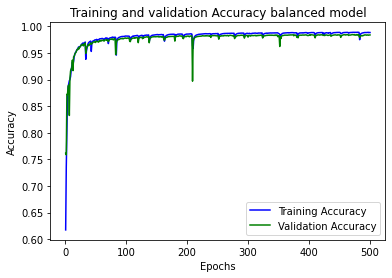

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and validation Accuracy balanced model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#label_masks={0 : "background",1 : 'sea', 2 : "vegetation", 3 : "miner"} 

In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction.shape

(292, 128, 128, 6)

In [ ]:
predicted_img=np.argmax(prediction, axis=3)[45,:,:]

In [ ]:
predicted_img.shape

(128, 128)

PREDICTION


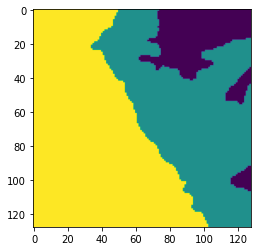

[3 4 5]
GROUND TRUTH


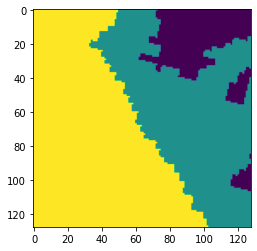

[3 4 5]


In [ ]:
print("PREDICTION")
plt.imshow(predicted_img)
plt.show()
print(np.unique(predicted_img))
print("GROUND TRUTH")
plt.imshow(y_test[45,:,:,0])
plt.show()
print(np.unique(y_test[45,:,:,0]))